# Data Visualization and Feature Selection

In this Markdown, we will first select some import features using the correlation matrix and then we would visualize the effects of the input features on the target that we want to predict. Then we will engineer some features so that the model will fit more easily and could better describe the effects we visualized in the below plots. 

## Unscaled Data Visualization

We first visualize the original data. By some trials, we would add some features like the changing rate of Volume, of bid price and so on to the data. Since we expect there is some information embedded in the dynamics of the number and we should not only focus on the values for the specific time and the change of the values should come into play. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from warnings import filterwarnings
filterwarnings("ignore")

data = pd.read_csv("data.csv")
data["Time"] = pd.to_datetime(data["Time"])
data.set_index("Time", inplace = True)

data["Bid Arrival"] = np.round(data["Bid Arrival"])
data["Ask Arrival"] = np.round(data["Ask Arrival"])

data["Bid Arr Pred"] = data["Bid Arrival"].shift(-1)
data["Ask Arr Pred"] = data["Ask Arrival"].shift(-1)

test_data = data[data.columns]
train_data = data[data.columns]

test_data = data.loc[data.index.floor("D") == pd.Timestamp('2017-06-01 00:00:00')]
train_data = data.loc[data.index.floor("D") != pd.Timestamp('2017-06-01 00:00:00')]

train_data = train_data.fillna(method="ffill")
test_data = test_data.fillna(method="ffill")


In [2]:

def add_features(data):

    data["diff Volume"] =data["Volume"].shift(-1) - data["Volume"]
    data["diff Turnover"] = data["Turnover"].shift(-1) - data["Turnover"]
    data["Mean Px Taken"] = (data["diff Turnover"]/data["diff Volume"]).fillna(method="ffill")
    data["Median Px"] = (data["Bid Px"] + data["Ask Px"])*0.5
    data["Median Px"] = data["Median Px"].fillna(method="ffill")
    data["diff Median Px"] = data["Median Px"].shift(-1) - data["Median Px"]
    data["diff Mean Px"] =  data["Mean Px Taken"].shift(-1) - data["Mean Px Taken"]
    data["diff Bid Px"] =  data["Bid Px"].shift(-1) - data["Bid Px"]
    data["diff Ask Px"] = data["Ask Px"].shift(-1) - data["Ask Px"] 

    data["log mean return"] = np.log(data["Median Px"].shift(-1)) - np.log(data["Median Px"]) 
    data["log mean return"] = data["log mean return"].fillna(method="ffill")


    data["imbalance"] = data["Bid Vol"] - data["Ask Vol"]

    data["Px gap"] = (data["Ask Px"] - data["Bid Px"])/data["Median Px"]

    data["Bid active"] = data["Bid Arrival"] - data["Bid Retreat"] - data["Bid Taken"]
    data["Ask active"] = data["Ask Arrival"] - data["Ask Retreat"] - data["Ask Taken"]


    data["volatile"] = data["log mean return"].rolling(5*30).std() # 30 = 1 mins
    data["volatile"] = data["volatile"].fillna(method="ffill")

    data["Last Px - Median Px"] = data["Last Px"] - data["Median Px"]

    data["abs(Last Px - Median Px)"] = np.absolute(data["Last Px - Median Px"])
    data["abs diff Median Px"] = np.absolute(data["diff Median Px"])
    data["abs diff Mean Px"] = np.absolute(data["diff Mean Px"])
    data["abs diff Bid Px"] =  np.absolute(data["diff Bid Px"])
    data["abs diff Ask Px"] = np.absolute(data["diff Ask Px"])
    data["abs Bid active"] = np.absolute(data["Bid active"])
    data["abs Ask active"] = np.absolute(data["Ask active"])



    data["Time from Open"] = (data.index - data.index.floor("D") ).astype('timedelta64[s]')
    return data

test_data = add_features(test_data)
train_data = add_features(train_data)
#data["Time from Open"] = data["Time from Open"] - np.amin(data["Time from Open"])

### Feature Selection

We first crudely get some feeling of the correlation of the input features and the prediction values. We see the features are are correlated with out target value are 

   - **Turnover**
   - **Volume**
   - **Bid Arrival**	
   - **Ask Arrival**	
   - **Bid Retreat**	
   - **Ask Retreat**	
   - **Bid Taken**	
   - **Ask Taken**	
   - **Bid Arr Pred**	
   - **Ask Arr Pred**	
   - **diff Median Px**: change of the Mean price: $(a(t) + b(t))/2$
   - **diff Bid Px** : change of the Bid Price $b(t)$.	
   - **diff Ask Px** : change of the Ask Price $a(t)$.	
   - **log mean return**: $ \log \text{Mean}_{t} - \log\text{Mean}_{t-1} $
   - **Px gap** : $a(t) - b(t)$. 
   - **volatile**	
   - **abs(Last Px - Median Px)**	
   - **abs diff Median Px**	
   - **abs diff Bid Px**	
   - **abs diff Ask Px**	
   - **abs Bid active**: The number of limit bid order in the LOB
   - **abs Ask active**: The number of limit ask order in the LOB
   - **Time from Open**: The time elapsed from the openning of the market	
    
From the data, we see the market opens early in the morning but just for a small time then, it officially opens at 9 am and there will be a lunch break each day. This is hilarious. ^_^.  

**We see the absolute value also plays import role in the prediciton. This is implies the behaviour of the order arrivals is different when the features change sign.** Below we will visualize the dependence of the features.


In [3]:
correlation = pd.DataFrame()
correlation["Bid Arr Pred"] = train_data.corr().loc["Bid Arr Pred"]
correlation["Ask Arr Pred"] = train_data.corr().loc["Ask Arr Pred"]


In [4]:
correlation.loc[np.logical_or(np.abs(correlation["Bid Arr Pred"]) > 0.08,
                              np.abs(correlation["Ask Arr Pred"]) > 0.08)
               ]

,Bid Arr Pred,Ask Arr Pred
Turnover,-0.104732,-0.113582
Volume,-0.103703,-0.112547
Bid Arrival,0.151832,0.110319
Ask Arrival,0.109869,0.167365
Bid Retreat,0.103869,0.067952
Ask Retreat,0.085584,0.109999
Bid Taken,0.109357,0.164330
Ask Taken,0.194470,0.144054
Bid Arr Pred,1.000000,0.149879
Ask Arr Pred,0.149879,1.000000


## Autocorrelation for Arrival of Orders

For autocorrlation plot, we are plotting correlation of the sequence with itself in the previous time points. In fact, we define the autocorrelation as 

$$
\gamma(s,t) = \frac{\text{Cov}(X_t, X_s)}{\text{Var}(X_t),\text{Var}(X_s) } .
$$

For stationary process, the autocorrelation only depends on the the time difference. Thus, we would estimate the autocorrelation for fixed value of $h \equiv |s - t|$ since we would have a lot of samples for the fixed time difference. From the below plot, we see the ACF is quite stationary and there is no fictious osicllating behaviour and thus the process is quite stationary. 

The definition of long memory is $$\sum_{h=0}^\infty \gamma(h)  \text{ diverges a.s.}$$
and this is equivalent to if $\gamma(h) \rightarrow h^{- \alpha} $ if $\alpha > 1$. 

Form the below plot, we see both ask and bid arrivals have decay exponents around $-0.2$ for correlations length $h< e^6 \approx 400$. Thus, the autocorrelation could be assumed to be zero since they are round $e^{-4.5} \approx 0.01$. Also, as the lag increases, the autocorrelation plot is more variant and the data should not be trusted. The coefficient we fitted here are $-0.278$ for ask arrival and $-0.21$ for bid arrivals. 


In [5]:
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.467
Model:                            OLS   Adj. R-squared:                  0.467
Method:                 Least Squares   F-statistic:                     788.1
Date:                Fri, 13 Nov 2020   Prob (F-statistic):          5.02e-125
Time:                        21:39:44   Log-Likelihood:                 294.01
No. Observations:                 901   AIC:                            -584.0
Df Residuals:                     899   BIC:                            -574.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.0154      0.061    -32.917      0.0

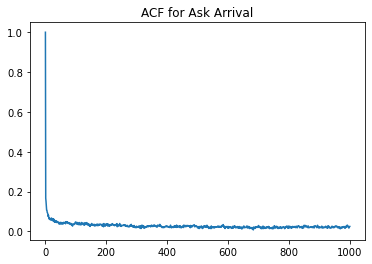

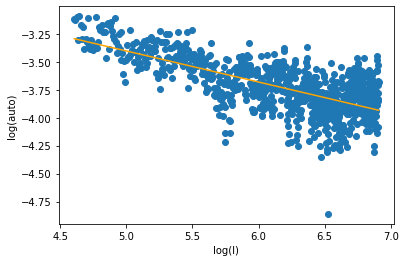

In [6]:
min_lags = 100
max_lags = 1000

lag_acf= acf(train_data["Ask Arrival"], nlags = max_lags, adjusted = True)
X = pd.DataFrame(np.log(np.arange(min_lags,max_lags+1)), columns=["log(l)"])
mod = sm.OLS(np.log(lag_acf[min_lags:max_lags+1]), sm.add_constant(X) )
res = mod.fit()
print (res.summary())


plt.figure()
plt.title("ACF for Ask Arrival")
plt.plot(lag_acf)
plt.show()

plt.figure()
plt.scatter(np.log(np.arange(min_lags,max_lags+1)), np.log(lag_acf[min_lags:max_lags+1]))
plt.plot(np.log(np.arange(min_lags,max_lags+1)), res.predict(), color="orange" )
plt.xlabel("log(l)")
plt.ylabel("log(auto)")
plt.savefig("./figs/ACF_ask.png")
plt.show()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     499.5
Date:                Fri, 13 Nov 2020   Prob (F-statistic):           2.44e-88
Time:                        21:39:46   Log-Likelihood:                 298.82
No. Observations:                 901   AIC:                            -593.6
Df Residuals:                     899   BIC:                            -584.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.4180      0.061    -39.703      0.0

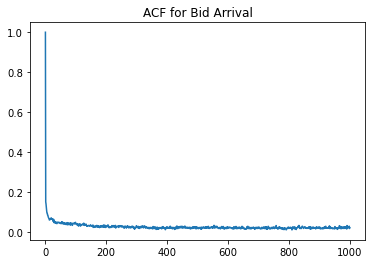

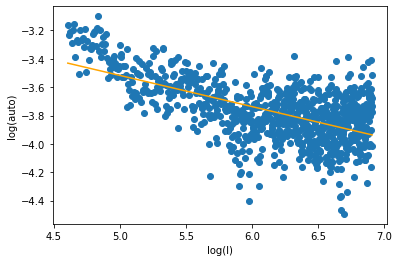

In [7]:
min_lags = 100
max_lags = 1000

lag_acf= acf(train_data["Bid Arrival"], nlags = max_lags, adjusted = True)
X = pd.DataFrame(np.log(np.arange(min_lags,max_lags+1)), columns=["log(l)"])
mod = sm.OLS(np.log(lag_acf[min_lags:max_lags+1]), sm.add_constant(X) )
res = mod.fit()
print (res.summary())


plt.figure()
plt.title("ACF for Bid Arrival")
plt.plot(lag_acf)
plt.show()

plt.figure()
plt.scatter(np.log(np.arange(min_lags,max_lags+1)), np.log(lag_acf[min_lags:max_lags+1]))
plt.plot(np.log(np.arange(min_lags,max_lags+1)), res.predict(), color="orange" )
plt.xlabel("log(l)")
plt.ylabel("log(auto)")
plt.savefig("./figs/ACF_bid.png")
plt.show()

## Data Visualization

In this part, we plot the order arrivals in the next time slot with different variables for the instant slot we are considering. In order to account for noise, we used bins to bin the variables and take median and average of the order arrivals in each bin. We actually found some interesting behaviours and make intuitive sense.

In [8]:
from scipy.stats import binned_statistic

def get_bin_plot(data, column, range, bins):

    plt.figure(figsize=(15,4))
    ax1 = plt.subplot(131)
    means, bins, binnumber = binned_statistic((data[column].iloc[1:-1]),
                                              data["Ask Arr Pred"].iloc[1:-1]>0 , 
                                              statistic = "mean",
                                              bins = bins,
                                              range = range)
    ax1.hlines(means, bins[:-1], bins[1:], lw = 2, colors = "b", label = "Ask")
    means, bins, binnumber = binned_statistic((data[column].iloc[1:-1]),
                                              data["Bid Arr Pred"].iloc[1:-1]>0 , 
                                              statistic = "mean",
                                              bins = bins,
                                              range = range)
    ax1.hlines(means, bins[:-1], bins[1:], lw = 2, colors = "g", linestyles = "dotted", label = "Bid")
    #ax1.legend(loc = "upper left")
    ax1.set_xlabel(column)
    ax1.title.set_text('Arrival Probability')
    
    ax2 = ax1.twinx() 
    ax2.hist(data[column], bins = bins, range = range, log = True, color = "gray", alpha = 0.2)

    ax1 = plt.subplot(132)
    means, bins, binnumber = binned_statistic((data[column].iloc[1:-1]),
                                              data["Ask Arr Pred"].iloc[1:-1], 
                                              statistic = "mean",
                                              bins = bins,
                                              range = range)
    ax1.hlines(means, bins[:-1], bins[1:], lw = 2, colors = "b", label = "Ask")
    means, bins, binnumber = binned_statistic((data[column].iloc[1:-1]),
                                              data["Bid Arr Pred"].iloc[1:-1], 
                                              statistic = "mean",
                                              bins = bins,
                                              range = range)
    ax1.hlines(means, bins[:-1], bins[1:], lw = 2, colors = "g", linestyles = "dotted", label = "Bid")
    #ax1.legend(loc = "upper left")
    ax1.set_xlabel(column)
    ax1.title.set_text('Arrival Mean')
    
    ax2 = ax1.twinx() 
    ax2.hist(data[column], bins = bins, range = range, log = True, color = "gray", alpha = 0.2)
    

    ax1 = plt.subplot(133)
    means, bins, binnumber = binned_statistic((data[column].iloc[1:-1]),
                                              data["Ask Arr Pred"].iloc[1:-1], 
                                              statistic = "median",
                                              bins = bins,
                                              range = range)
    ax1.hlines(means, bins[:-1], bins[1:], lw = 2, colors = "b", label = "Ask")
    means, bins, binnumber = binned_statistic((data[column].iloc[1:-1]),
                                              data["Bid Arr Pred"].iloc[1:-1], 
                                              statistic = "median",
                                              bins = bins,
                                              range = range)
    ax1.hlines(means, bins[:-1], bins[1:], lw = 2, colors = "g", linestyles = "dotted", label = "Bid")
    ax1.legend(bbox_to_anchor=(1.25,1.0))
    ax1.set_xlabel(column)
    ax1.title.set_text("Arrival median")
    
    ax2 = ax1.twinx() 
    ax2.hist(data[column], bins = bins, range = range, log = True, color = "gray", alpha = 0.2)
    
    ax2.set_ylabel("count")
    plt.savefig("./figs/densities/density_"+column+".png")
    plt.show()
                                              

### Turnover:

Here we see the more turnover is, the less likely and less amount of orders will be posted. Also, the most of time slots are concentrated on the larger turnover as we can read from the gray histograms. This because the turnover reaches a high value soonly (using small amount of time) and then stablized there for quite a long time. Since the turnover is correlated with the time to close the market (turnover is an increas function of time), we can interpret that the closer to the close time, the less reluctant for the traders to transact. 

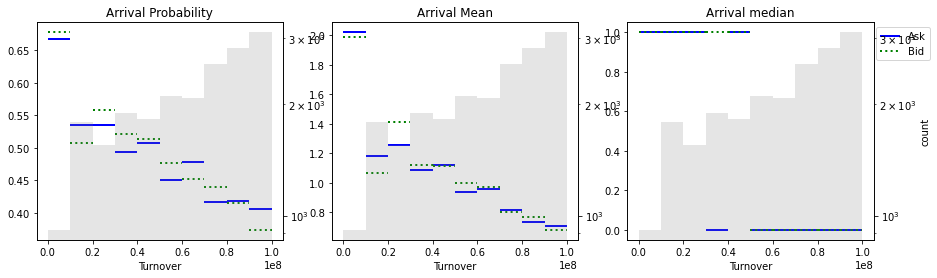

In [9]:
get_bin_plot(train_data, "Turnover", (1e1,1e8),10)

### Volume 

We see as the volume increases, the orders regardless of bid or ask are more reluctant to arrive. This is because the volume is an increasing function of the time and the closer to the close time, the less orders would be put since the market will close. Also, people tend to use the whole day to try their luck for the limit order to transact and thus people tend to put orders at the begining of the market.

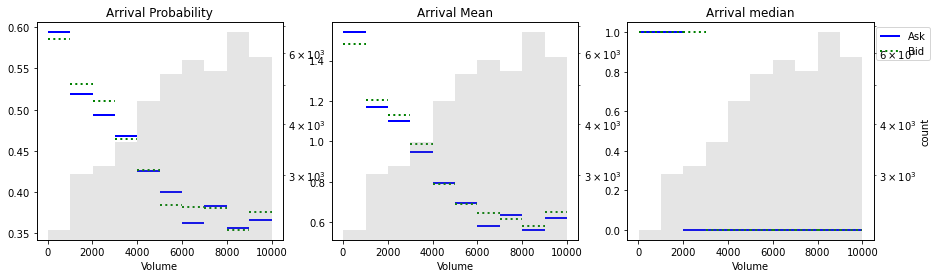

In [10]:
get_bin_plot(train_data, "Volume", (1e1,1e4),10)

### Bid Arrival & Ask Arrival

Here, we can see the more bid orders arriving, the more bid will arrive as well as the ask. The bid orders arrive because people tend to trunk their orders into small quantities and hide their intention to buy and thus more bid orders will arive after the arrived bid orders. Another interpretation is that people tend to follow others' strategy and information. If there are more intention to buy the stock, then it would either be because the demand increases or because people wants to profit from future high price sale. 

An interesting fact we observed is that the probability for bid orders are higher than the probaility of selling it when the demand of buying is large. This is because if more people want to buy then we would better to store our goods and sell it in the future. 

We observe similar trend if we replace the x axis as the Ask Arrivals. The role of Ask and Bid in the y axis exchanges. This is because if more people wants to sell it, then it would not be worthwhile to buy it. 


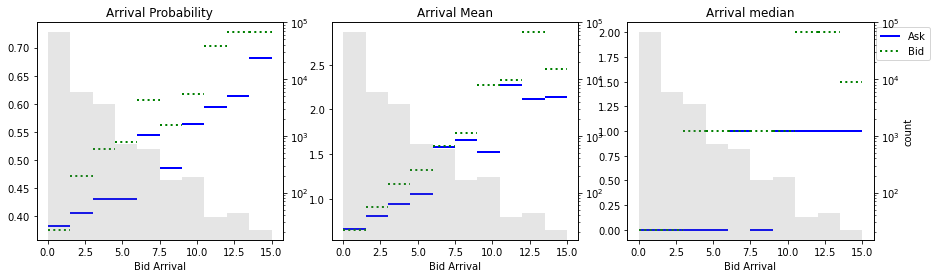

In [11]:
get_bin_plot(train_data, "Bid Arrival", (0,15),10)

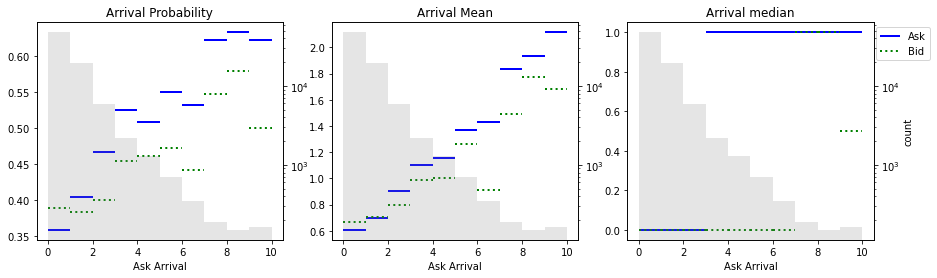

In [11]:
get_bin_plot(train_data, "Ask Arrival", (0,10),10)

### Bid Retreat & Ask Retreat 

Here we see the more Bid retreat there is, there will be more bid orders. This may be because in the high frequency trading, traders' algorithms using retreated orders to search for hidden liquidity. The more retreated orders means there are more people searching for the liqudity and there will be more submission of orders. However, the probability of increase is not that severe and we believe the factor of retreat is not the most important. 


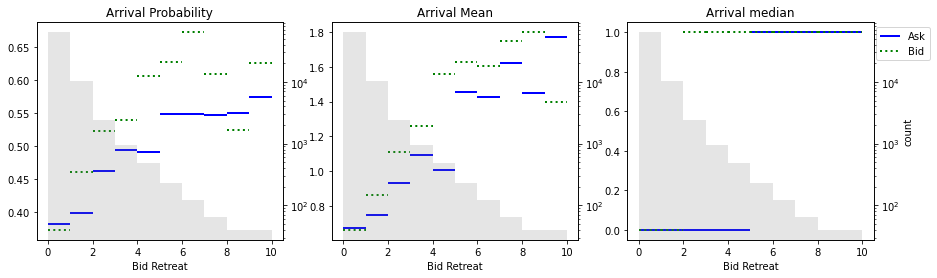

In [12]:
get_bin_plot(train_data, "Bid Retreat", (0,10),10)

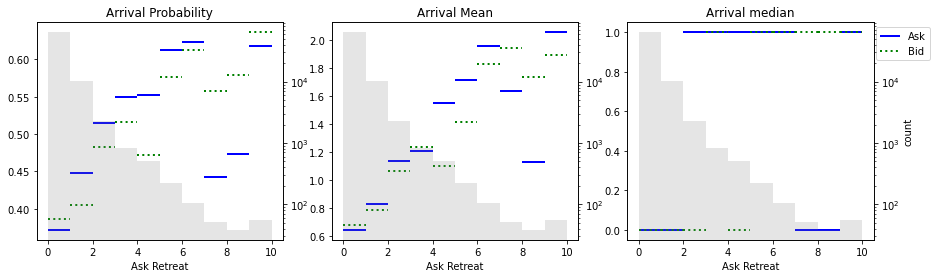

In [13]:
get_bin_plot(train_data, "Ask Retreat", (0,10),10)

### Bid Taken & Ask Taken

We see that the more bid orders and ask orders are taken, the more bid orders and ask orders will arrive. This make intuitive sense since if more bid orders are actually transacted during the past moment, means people are willing to actual buy and sell it simultaneously. The reason that the Ask order is higher than the bid order for the same amount of bid taken is that if people actually are selling them then it would be better to follow the trend and sell it since now the probability of selling it out is high. 


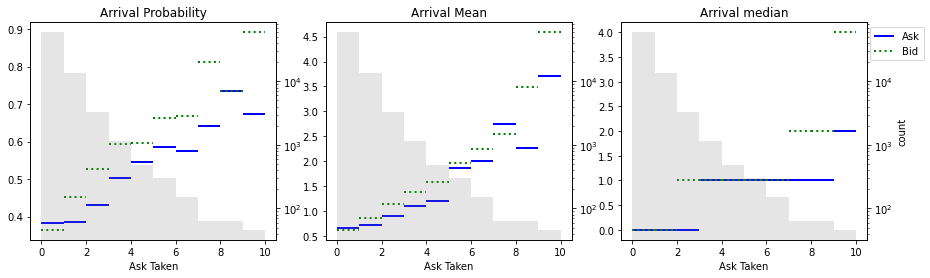

In [14]:
get_bin_plot(train_data, "Ask Taken", (0,10),10)

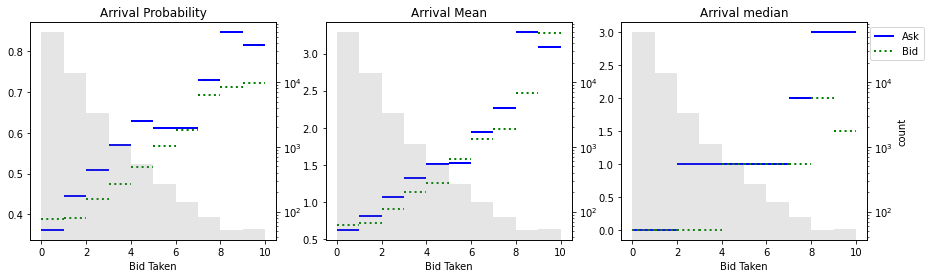

In [15]:
get_bin_plot(train_data, "Bid Taken", (0,10),10)

### Median Price changing rate

If the middle price between the $a(t)$ and $b(t)$ is increasing, the stock will be more valuable in the future and thus, more bid arrivals will take place. Then although the selling traders will follow the buying trend to sell some but the amount will not be as high as the bidding orders. 

Similarly, when the price decreases (the negative part of the Meidan price), more people will sell it since they want to make sure their profit is maximized. Then the buying traders, will follow the trend since they will buy the stock at a good value but the amount of buying will not be as high as the selling amount. 


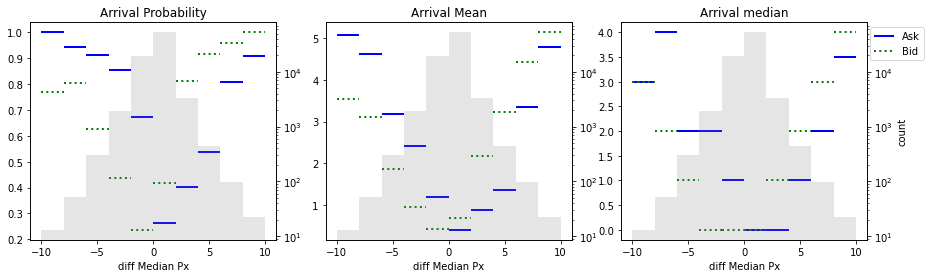

In [16]:
get_bin_plot(train_data, "diff Median Px", (-10,10),10)

### Bid Price changing rate

If the highest bidding price is increasing, then we find the probability of bidding orders to arrive is almost one. We can interpret this as that if the highest bidding price increases, then people are more willing to buy it than selling it. Then this means people are very optimistic about the future of the stock. Thus, the buying orders will definitely arrive. Although people will sell some but it is not as high as the selling orders. 

On the other hand if, the bidding price decreases, then this signals the demand for the stock decreases. Thus, people will tend to sell it. But people won't sell it every time the bidding price decreases even though when it decreases a lot. This may be because people tend to hope the price will rise again. 

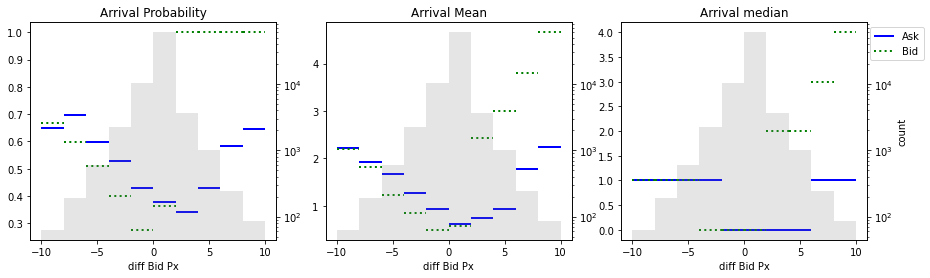

In [17]:
get_bin_plot(train_data, "diff Bid Px", (-10,10), 10)

### Ask Price changing rate

The behaviour is similar to the above case. Specifically, if the lowest selling price are decreasing, this means people tend to sell it desperately, and for sure more and more selling orders will come. But if the selling price are increasing, people will also tend to sell it since they will profit from the rising selling price. 

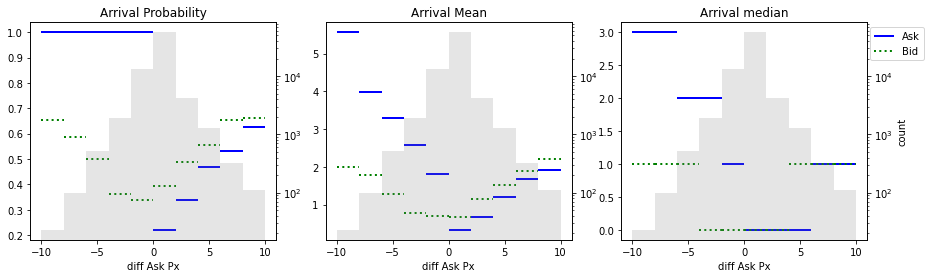

In [18]:
get_bin_plot(train_data, "diff Ask Px", (-10,10),10)

### log mean return 

This quantity is the log of return by mean price. This behaviour is similar to the Median price changing rate as they are measuring how the mean price changes over the time step. 

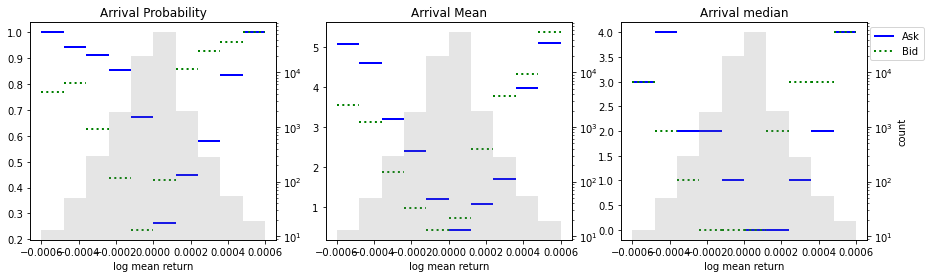

In [19]:
get_bin_plot(train_data, "log mean return", (-0.0006,0.0006),10)

### The price gap

The gap between the bidding and ask price also signals the arrival of orders. If the prcie gap increases, people tend to submit more orders since they won't risk the lower price of selling or higher price of buying. 

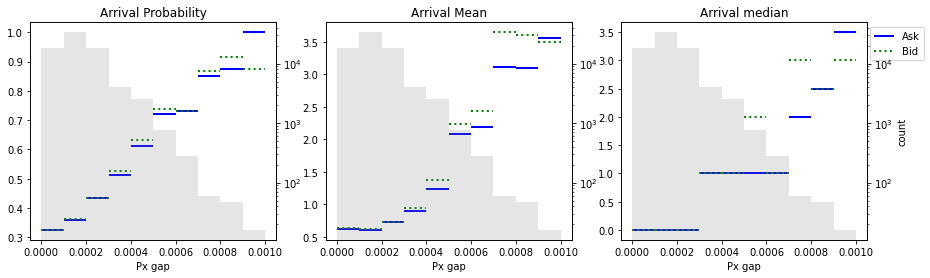

In [20]:
get_bin_plot(train_data, "Px gap", (0.0, 0.0010), 10)

### Volatile

We see there is a increase trend for orders with increasing volatile. However the slope is not as steep as the previous cases and we do not think the volatile means a lot for the amount of orders to arrive

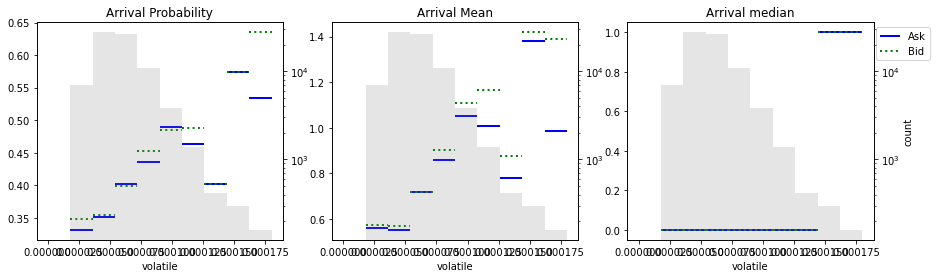

In [30]:
get_bin_plot(train_data, "volatile", (0.0, 0.00018), 10)

### The difference between the last transacted Price and Median Price

We see although there is some V shaped behaviour but the mean of the y axis is oscillating and the probability of order arrivals do not change much 

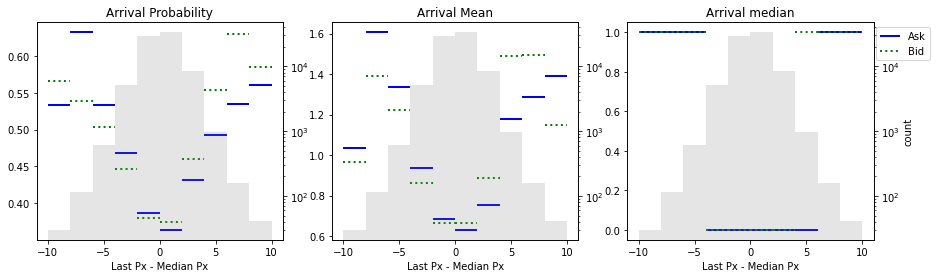

In [22]:
get_bin_plot(train_data,"Last Px - Median Px", (-10,10), 10)

### Time from Open:

We see as the time to close of market approaches, the orders are more reluctant to arrive. This makes perfect sense since the orders left will be canceled at the time of close. Thus, the submission of orders which will show the intention of the traders' strategy will not gain much compared to what it costs. Since the Volume and Time from Open are correlated, we expect we do not need both of them in the final model we would use. 

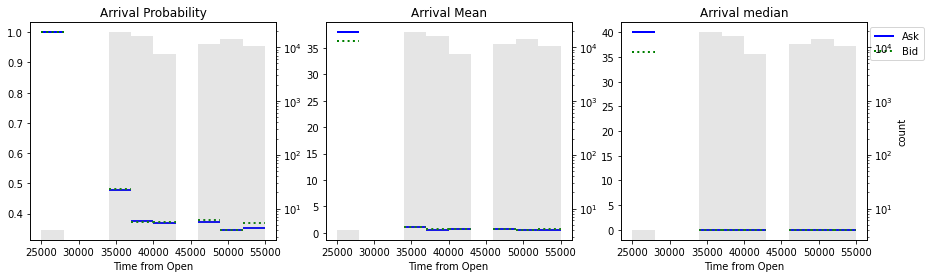

In [29]:
get_bin_plot(train_data,"Time from Open", (2.5e4,5.5e4), 10)

### The most important features:

Here we select the most import features where the probability and median change a lot by varying the horizontal feature. The most important features are:

 - Bid Taken
 - Ask Taken
 - Median Price change rate
 - Bid Price change rate
 - Ask Price change rate
 - log mean return
 - The price gap 
 
Then below we will plot the order flow verses the absolute values of the features with V-shaped plot to confirm that the behaviour of V-shape. 

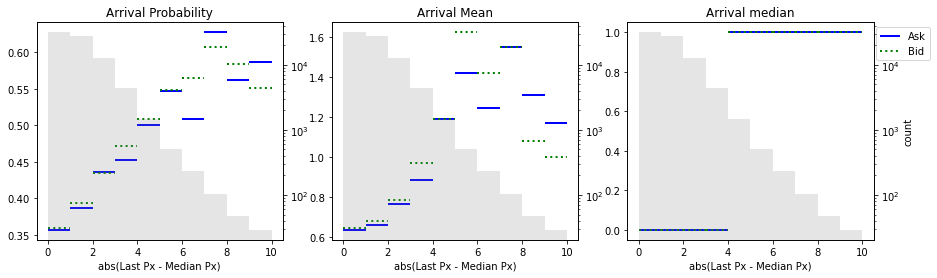

In [23]:
get_bin_plot(train_data,"abs(Last Px - Median Px)", (0,10), 10)

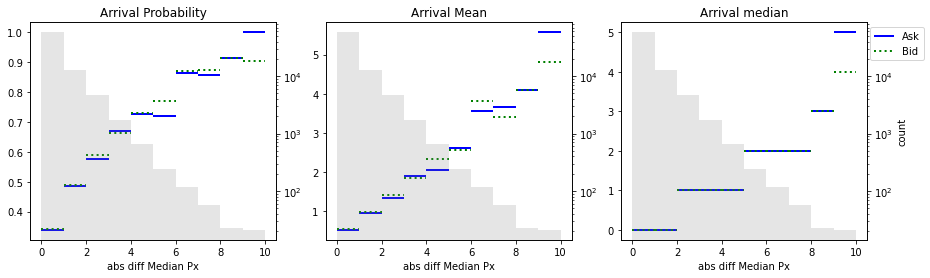

In [24]:
get_bin_plot(train_data, "abs diff Median Px", (0,10),10)

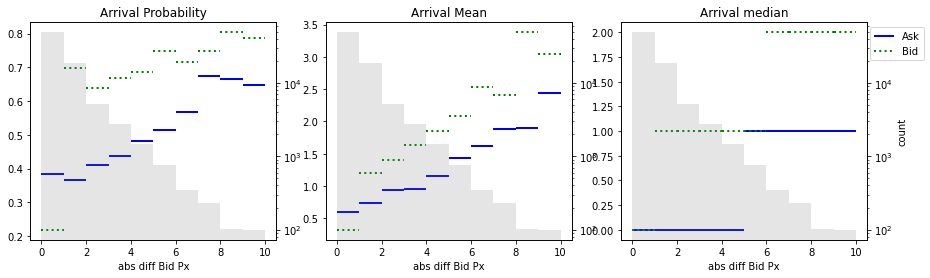

In [25]:
get_bin_plot(train_data, "abs diff Bid Px", (0,10),10)

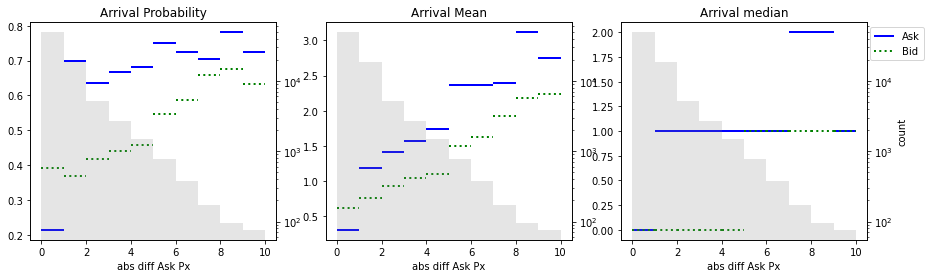

In [26]:
get_bin_plot(train_data, "abs diff Ask Px", (0,10),10)

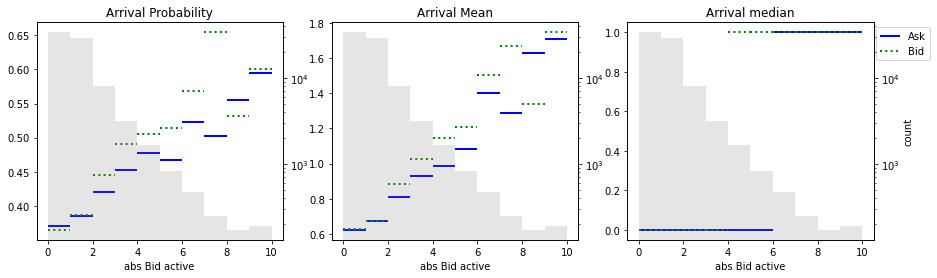

In [27]:
get_bin_plot(train_data, "abs Bid active", (0,10),10)

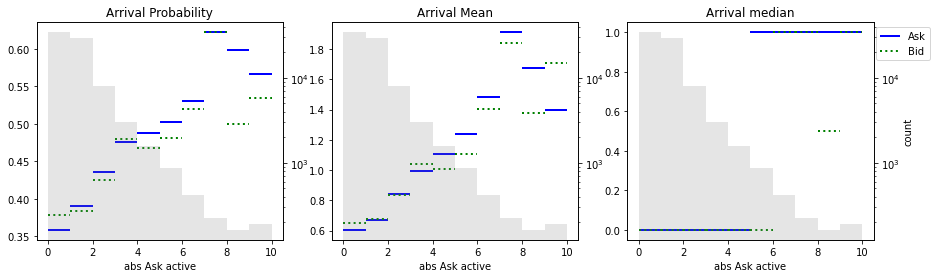

In [28]:
get_bin_plot(train_data, "abs Ask active", (0,10),10)

## Scaled Data Visualization

Since we will standardize our data to do the regression, we will visulaize the trend and check the knowledge we gained before using the unnormalized data. 

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("data.csv")
data["Time"] = pd.to_datetime(data["Time"])
data.set_index("Time", inplace = True)

data["Bid Arrival"] = np.round(data["Bid Arrival"])
data["Ask Arrival"] = np.round(data["Ask Arrival"])

data["Bid Arr Pred"] = data["Bid Arrival"].shift(-1)
data["Ask Arr Pred"] = data["Ask Arrival"].shift(-1)

test_data = data[data.columns]
train_data = data[data.columns]

test_data = data.loc[data.index.floor("D") == pd.Timestamp('2017-06-01 00:00:00')]
train_data = data.loc[data.index.floor("D") != pd.Timestamp('2017-06-01 00:00:00')]

train_data = train_data.fillna(method="ffill")
test_data = test_data.fillna(method="ffill")

def add_features(data):

    data["diff Volume"] =data["Volume"].shift(-1) - data["Volume"]
    data["diff Turnover"] = data["Turnover"].shift(-1) - data["Turnover"]
    data["Mean Px Taken"] = (data["diff Turnover"]/data["diff Volume"]).fillna(method="ffill")
    data["Median Px"] = (data["Bid Px"] + data["Ask Px"])*0.5
    data["Median Px"] = data["Median Px"].fillna(method="ffill")
    data["diff Median Px"] = data["Median Px"].shift(-1) - data["Median Px"]
    data["diff Mean Px"] =  data["Mean Px Taken"].shift(-1) - data["Mean Px Taken"]
    data["diff Bid Px"] =  data["Bid Px"].shift(-1) - data["Bid Px"]
    data["diff Ask Px"] = data["Ask Px"].shift(-1) - data["Ask Px"] 

    data["log mean return"] = np.log(data["Median Px"].shift(-1)) - np.log(data["Median Px"]) 
    data["log mean return"] = data["log mean return"].fillna(method="ffill")


    data["imbalance"] = data["Bid Vol"] - data["Ask Vol"]

    data["Px gap"] = (data["Ask Px"] - data["Bid Px"])/data["Median Px"]

    data["Bid active"] = data["Bid Arrival"] - data["Bid Retreat"] - data["Bid Taken"]
    data["Ask active"] = data["Ask Arrival"] - data["Ask Retreat"] - data["Ask Taken"]


    data["volatile"] = data["log mean return"].rolling(5*30).std() # 30 = 1 mins
    data["volatile"] = data["volatile"].fillna(method="ffill")

    data["Last Px - Median Px"] = data["Last Px"] - data["Median Px"]

    
    data["Time from Open"] = (data.index - data.index.floor("D") ).astype('timedelta64[s]')
        
    return data  
        
def add_abs_features(data):    
    data["abs(Last Px - Median Px)"] = np.absolute(data["Last Px - Median Px"])
    data["abs diff Median Px"] = np.absolute(data["diff Median Px"])
    data["abs diff Mean Px"] = np.absolute(data["diff Mean Px"])
    data["abs diff Bid Px"] =  np.absolute(data["diff Bid Px"])
    data["abs diff Ask Px"] = np.absolute(data["diff Ask Px"])
    data["abs Bid active"] = np.absolute(data["Bid active"])
    data["abs Ask active"] = np.absolute(data["Ask active"])

    return data
    

test_data = add_features(test_data)
train_data = add_features(train_data)

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler

imputer = SimpleImputer()
scaler = RobustScaler()

trainX = train_data.drop(columns = ["Bid Arr Pred", "Ask Arr Pred"])
testX = test_data.drop(columns = ["Bid Arr Pred", "Ask Arr Pred"])

trainX_imputed = imputer.fit(trainX).transform(trainX)
testX_imputed = imputer.transform(testX)

trainX_scaled = scaler.fit(trainX_imputed).transform(trainX_imputed)
testX_scaled = scaler.transform(testX_imputed)


train_data[trainX.columns] = trainX_scaled
test_data[testX.columns] = testX_scaled

test_data = add_abs_features(test_data)
train_data = add_abs_features(train_data)

### Feature Selection

We see the variables we selected using the scaled parameters via the correlation are almost the same as above. Thus, we will plot similar plots below. 

In [62]:
correlation = pd.DataFrame()
correlation["Bid Arr Pred"] = train_data.corr().loc["Bid Arr Pred"]
correlation["Ask Arr Pred"] = train_data.corr().loc["Ask Arr Pred"]

,Bid Arr Pred,Ask Arr Pred
Last Px,-0.007163,-0.007025
Turnover,-0.104732,-0.113582
Volume,-0.103703,-0.112547
Bid Px,-0.007728,-0.007130
Bid Vol,0.006880,0.004483
Ask Px,-0.006287,-0.005833
Ask Vol,0.002168,0.004178
Bid Arrival,0.151832,0.110319
Ask Arrival,0.109869,0.167365
Bid Retreat,0.103869,0.067952


In [63]:
correlation.loc[np.logical_or(np.abs(correlation["Bid Arr Pred"]) > 0.08,
                              np.abs(correlation["Ask Arr Pred"]) > 0.08)
               ]

,Bid Arr Pred,Ask Arr Pred
Turnover,-0.104732,-0.113582
Volume,-0.103703,-0.112547
Bid Arrival,0.151832,0.110319
Ask Arrival,0.109869,0.167365
Bid Retreat,0.103869,0.067952
Ask Retreat,0.085584,0.109999
Bid Taken,0.109357,0.164330
Ask Taken,0.194470,0.144054
Bid Arr Pred,1.000000,0.149879
Ask Arr Pred,0.149879,1.000000


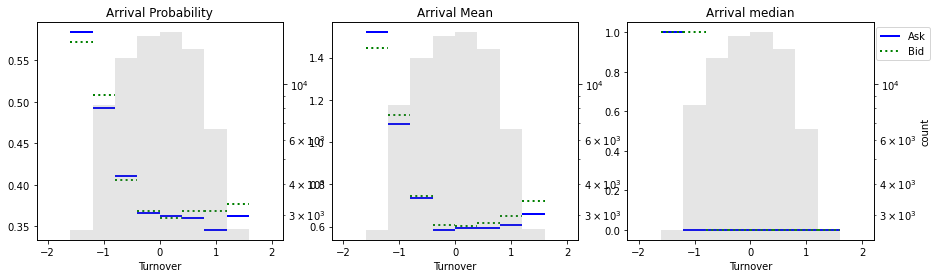

In [64]:
get_bin_plot(train_data, "Turnover", (-2.0,2.0),10)

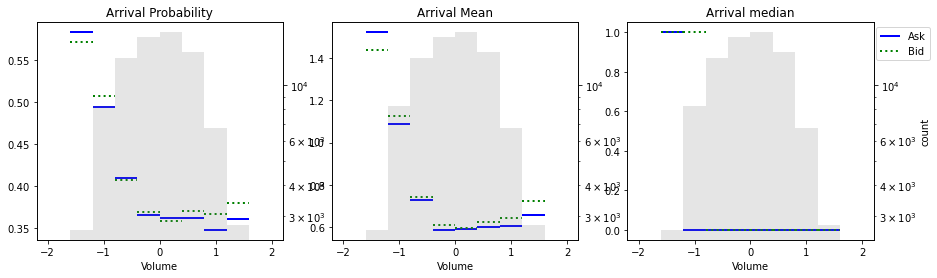

In [65]:
get_bin_plot(train_data, "Volume", (-2.0, 2.0),10)

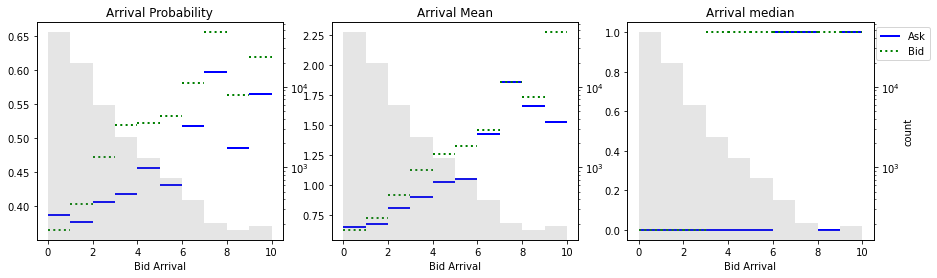

In [66]:
get_bin_plot(train_data, "Bid Arrival", (0,10),10)

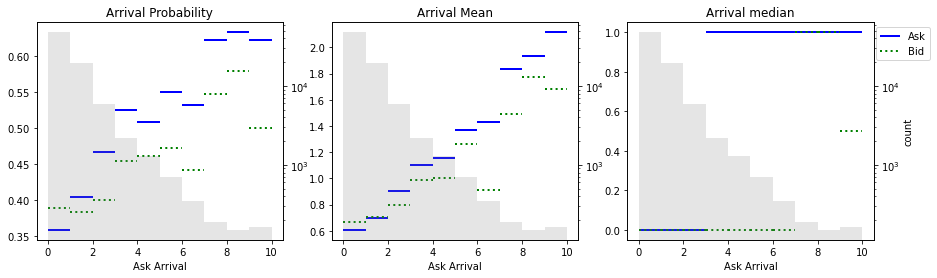

In [67]:
get_bin_plot(train_data, "Ask Arrival", (0,10),10)

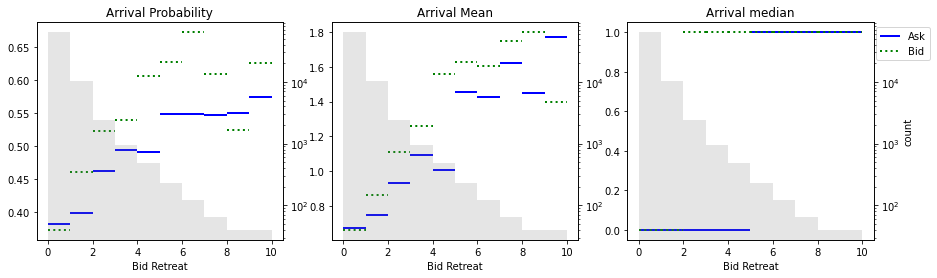

In [68]:
get_bin_plot(train_data, "Bid Retreat", (0,10),10)

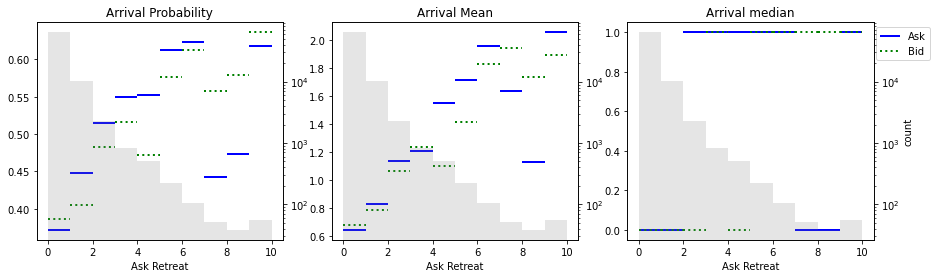

In [69]:
get_bin_plot(train_data, "Ask Retreat", (0,10),10)

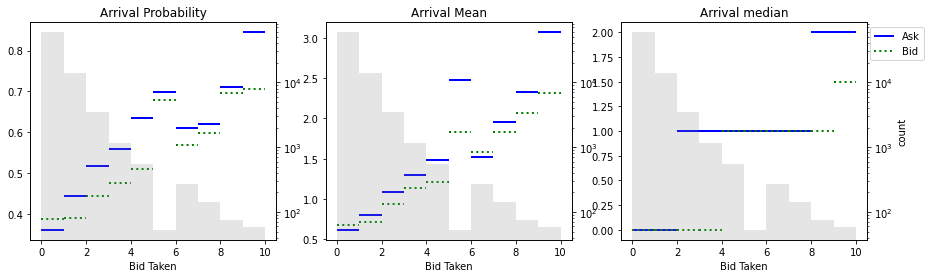

In [70]:
get_bin_plot(train_data, "Bid Taken", (0,10),10)

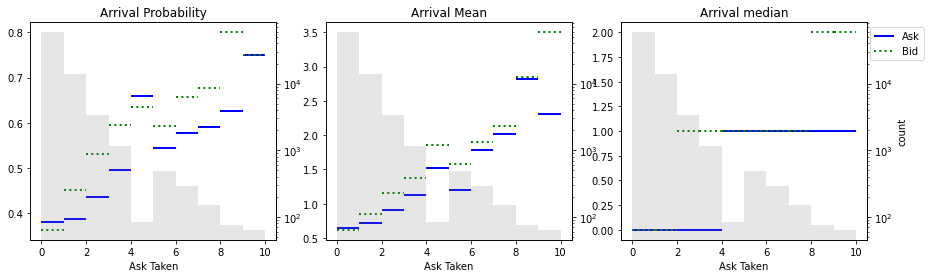

In [71]:
get_bin_plot(train_data, "Ask Taken", (0,10),10)

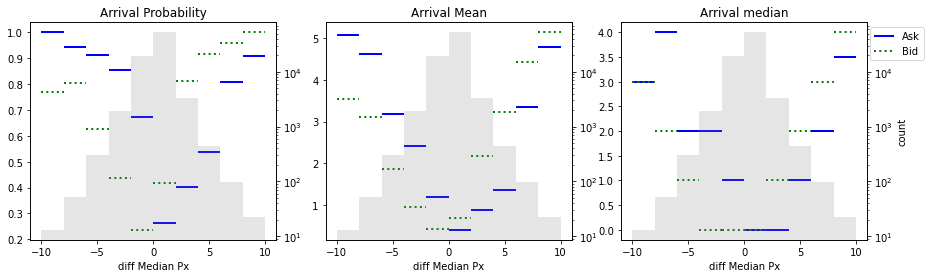

In [72]:
get_bin_plot(train_data, "diff Median Px", (-10,10),10)

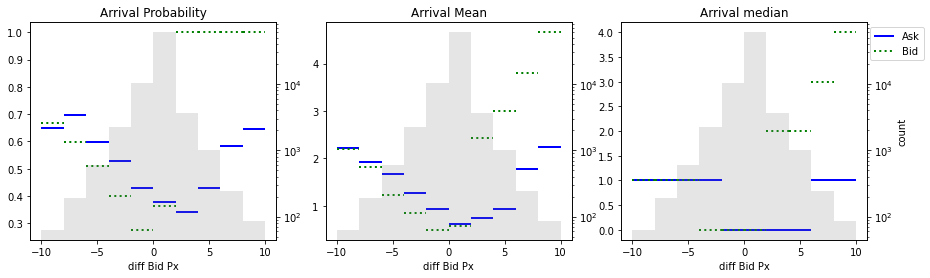

In [73]:
get_bin_plot(train_data, "diff Bid Px", (-10,10), 10)

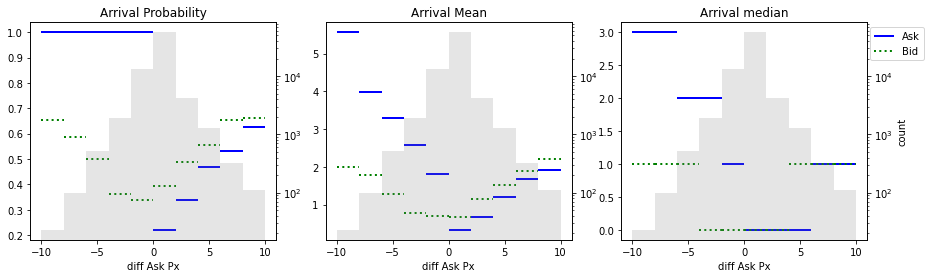

In [74]:
get_bin_plot(train_data, "diff Ask Px", (-10,10),10)

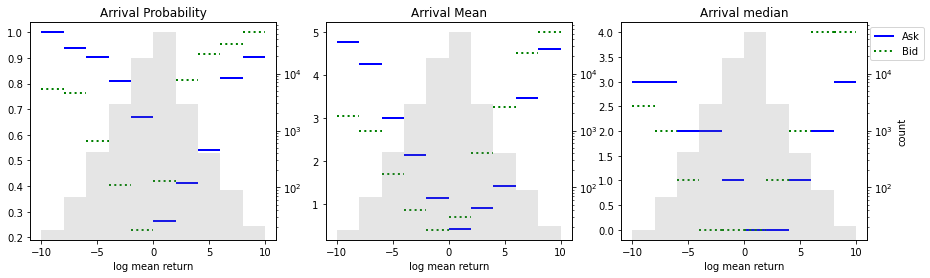

In [75]:
get_bin_plot(train_data, "log mean return", (-10.0, 10.0),10)

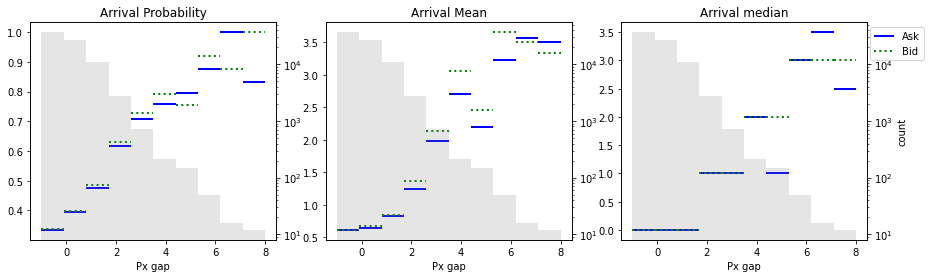

In [76]:
get_bin_plot(train_data, "Px gap", (-1, 8), 10)

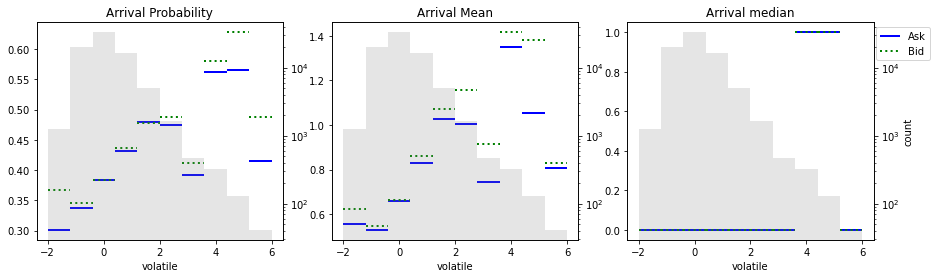

In [77]:
get_bin_plot(train_data, "volatile", (-2, 6), 10)

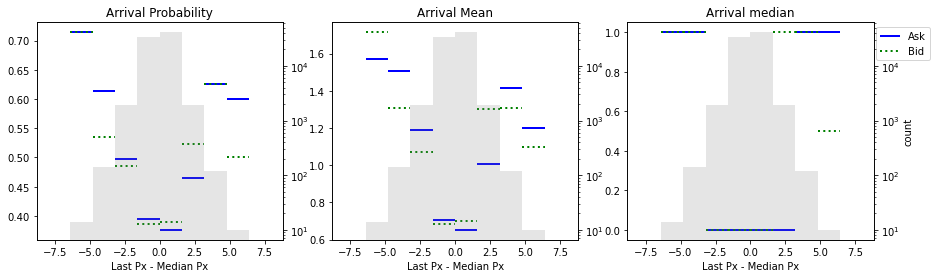

In [78]:
get_bin_plot(train_data,"Last Px - Median Px", (-8,8), 10)

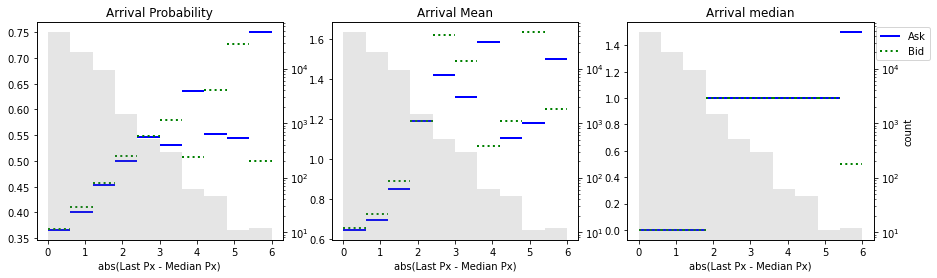

In [79]:
get_bin_plot(train_data,"abs(Last Px - Median Px)", (0,6), 10)

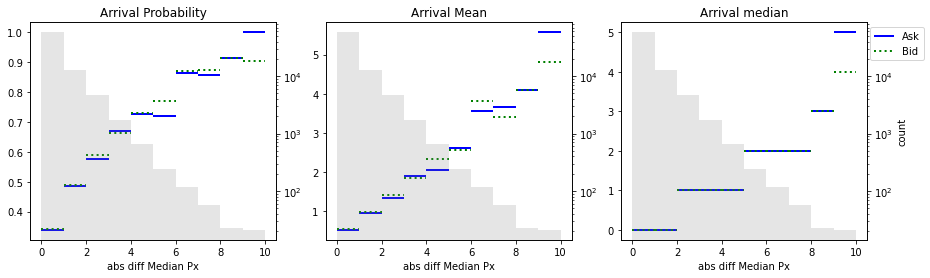

In [80]:
get_bin_plot(train_data, "abs diff Median Px", (0,10),10)

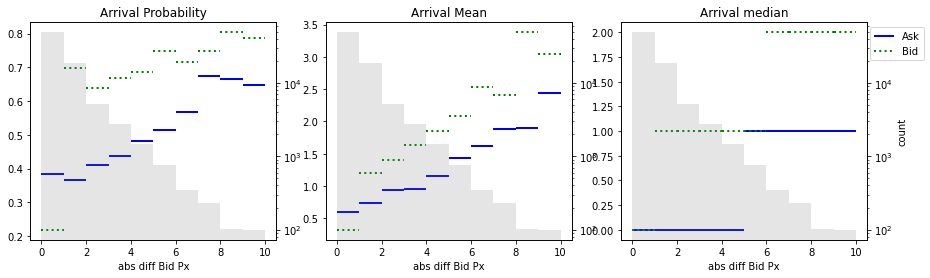

In [81]:
get_bin_plot(train_data, "abs diff Bid Px", (0,10),10)

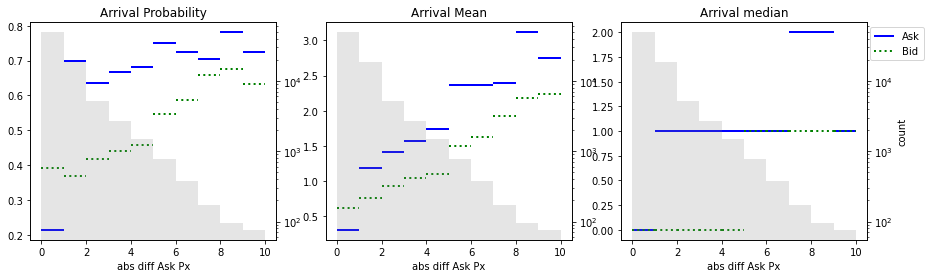

In [82]:
get_bin_plot(train_data, "abs diff Ask Px", (0,10),10)

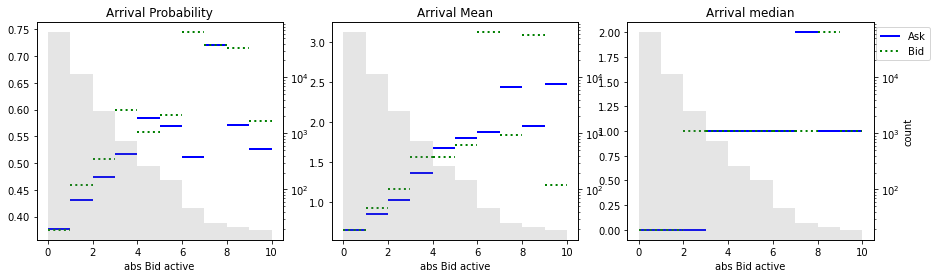

In [83]:
get_bin_plot(train_data, "abs Bid active", (0,10),10)

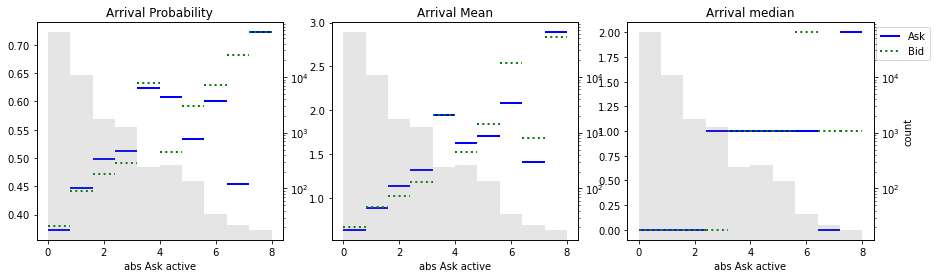

In [84]:
get_bin_plot(train_data, "abs Ask active", (0,8),10)